In [1]:
from pykat import finesse 
       
from pykat.commands import *     
import numpy as np               
import matplotlib.pyplot as plt  
import scipy                     
from IPython import display

              

pykat.init_pykat_plotting(dpi=200)

kat=finesse.kat()
kat_PRM=finesse.kat()
kat.verbose=1
kat_PRM.verbose=1

                                              ..-
    PyKat 1.2.81          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



<h2>BASECODE</h2>

<p>Input Laser ---> BS for PRM angular sensing ---> PRM ---> BS for ITM/ETM sensing ---> ITM ---> ETM</p>

In [2]:
kat.parse("""

maxtem 3
l laser 30 0 n1                          #laser 1W
s gap01 1 n1 n2                         #space b/w mod and laser  
mod sb1 55.5556M 0.18 3 pm n2 n3         #modulator PM 55.5556M 3f
s gap02 0.5 n3 n31                     #space b/w mod and PRM      


##### FOR ANGULAR SENSING PRM #####
bs pickoff 0.0001 0.9999 0 45 n31 dump n32 refl_a
s s2 0.1 refl_a a8                       
bs bsQPD 0.5 0.5 0 45 a8 a9 a10 dump            #bs to split power between two detectors 

s sQPD1 0.1 a9 a11                   
s sQPD2 0.1 a10 a12

attr s2 g 45                                 #guoy phase for det1
attr sQPD1 g 160                                 #guoy phase for det1
attr sQPD2 g 250                                #guoy phase for det2

pd1 QPDrefl1 166.6668M 0 a11                       #Split detector1 refl
pdtype QPDrefl1 x-split   
pd1 QPDrefl2 166.6668M 90 a12                       #Split detector2 refl
pdtype QPDrefl2 x-split  


### scale all QPDs outputs ###
set QPDrefl1n QPDrefl1 re
func QPDrefl1_PRM = $QPDrefl1n*10000000
set QPDrefl2n QPDrefl2 re
func QPDrefl2_PRM = $QPDrefl2n*10000000
###############################

#######################


##### FOR ANGULAR SENSING ITM/ETM #####
s sr 0.01 n12 n12a    
bs pickoff1 0.0001 0.9999 0 45 n12a dump n121 refl_itm
s s21 0.1 refl_itm a81                       
bs bsQPD1 0.5 0.5 0 45 a81 a91 a101 dump            #bs to split power between two detectors 

s sQPD11 0.1 a91 a11a                   
s sQPD21 0.1 a101 a12a

attr s21 g 10                                 #guoy phase for det1
attr sQPD11 g 80                                 #guoy phase for det1
attr sQPD21 g 350                                #guoy phase for det2

pd1 QPDrefl1_itm 55.5556M 0 a11a                       #Split detector1 refl
pdtype QPDrefl1_itm x-split   
pd1 QPDrefl2_itm 55.5556M 90 a12a                       #Split detector2 refl
pdtype QPDrefl2_itm x-split  

#########################



####### 3 m setup ###########

s gap03 0.5 n32 refl

m PRM 0.759 0.1 90 refl pop               #PRM                ---> POP <---
#m PRM 0 1 90 refl pop               #PRM
s PRC 1.350 pop b3                        #PRC 
m ITM 0.98997 0.01 0 b3 n12              #ITM
s ARM 3.29 n121 b5                        #ARM length 3.3 (0.01 from sr length) 
m ETM 0.99996 0.00001 90 b5 b6           #ETM
#m ETM 0 1 0 b5 b6 

################################
cav ARML ITM n12 ETM b5 
cav PRCL PRM pop ITM b3

trace 2 


##### attr for TM ######

attr ETM Rc 11.3            # RoC of ETM
attr PRM Rc -23.6           # RoC of PRM

attr PRM xbeta 0            # misalgnment 
attr ETM xbeta 0         
attr ITM xbeta 0 
######################


##### PD #######

pd circ_arm b5
pd circ_prc pop
pd refl refl
pd trans b6
 

pd1 refl_I 55.5556M 0 refl_a              # REFL I  1f
pd1 refl_Q 55.5556M 90 refl_a             # REFL Q  1f
pd1 refl_I_f3 166.6668M 0 refl_a          # REFL I  3f
pd1 refl_Q_f3 166.6668M 90 refl_a         # REFL Q  3f
pd1 pop_I_raw 55.5556M 0 pop                # POP I  1f
pd1 pop_Q_raw 55.5556M 90 pop               # POP Q  1f
pd1 pop_I_f3_raw 166.6668M 0 pop            # POP I  3f
pd1 pop_Q_f3_raw 166.6668M 90 pop           # POP Q  3f

################






#x2axis ITM xbeta lin -0.3m 0.3m 800            #for 3d graph plotting

#xaxis PRM xbeta lin 0 0.3m 200
#xaxis ETM phi lin 85 95 900
#func prm_tune = 90 + $x1*0.1
#put PRM phi $prm_tune
yaxis lin abs

 

""")

Parsing `set QPDrefl1n QPDrefl1 re` into pykat object not implemented yet, added as extra line.
Parsing `set QPDrefl2n QPDrefl2 re` into pykat object not implemented yet, added as extra line.


<h2>  ETM Angular Sensing</h2>

In [3]:
kat_ETM = kat.deepcopy()
kat_ETM.parse("""


#### LOCK ETM ####
set errs pop_I_f3_raw re
func errs4 = $errs*0.1
lock clocks $errs4 -3000 0.1n
put* ETM phi $clocks
noplot clocks
#####


xaxis ETM xbeta lin 0 25u 500

#xaxis ETM phi lin 80 100 500

""")

out1 = kat_ETM.run()
out1.info()
#out.plot()

Parsing `set errs pop_I_f3_raw re` into pykat object not implemented yet, added as extra line.
--------------------------------------------------------------
Running kat - Started at 2022-10-21 22:16:17.956509


100% | ETA:  0:00:00 | Calculating - Locked ✓ (Locking steps tried 12/10000)   

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 13.4706 seconds

--- Output info ---

Run date and time: 2022-10-21 22:16:17.957515
Detectors used: QPDrefl1, QPDrefl1_PRM, QPDrefl1_itm, QPDrefl2, QPDrefl2_PRM, QPDrefl2_itm, circ_arm, circ_prc, clocks, errs4, pop_I_f3_raw, pop_I_raw, pop_Q_f3_raw, pop_Q_raw, refl, refl_I, refl_I_f3, refl_Q, refl_Q_f3, trans

One xaxis used: ['xaxis ETM xbeta lin 0 2.5e-05 500']
QPDrefl1     : min = -7.279444777545590e-10 max = 0.000000000000000e+00
QPDrefl2     : min = -3.200900495320980e-10 max = 0.000000000000000e+00
QPDrefl1_itm : min = -1.964393131262630e-05 max = 0.000000000000000e+00
QPDrefl2_itm : min = 0.000000000000000e+00 max = 1.347135613063480e-04
circ_arm     : min = 3.483023677341320e+04 max = 3.657320815519020e+04
circ_prc     : min = 9.548179735789550e+01 max = 9.983353866387201e+01
refl         : min = 3.205159985132040e+00 max = 4.210678325766830e+00
trans        : min = 3.483164431592250e-01 max = 3.6

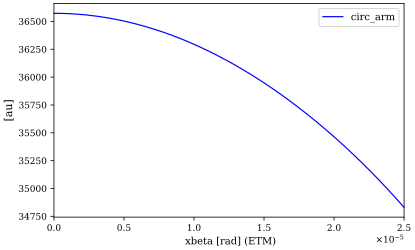

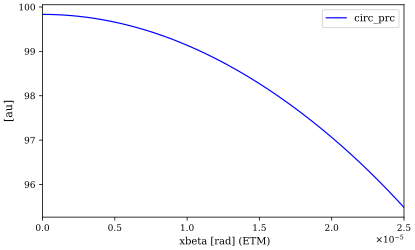

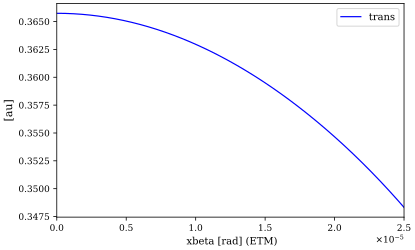

In [4]:
out1.plot(['circ_arm'])
out1.plot(['circ_prc'])
out1.plot(['trans'])

In [5]:
#out1.plot(['refl_Q','refl_I'])
#out1.plot(['refl_I_f3','refl_Q_f3'])
#
#out1.plot(['pop_I_raw','pop_Q_raw'])
#out1.plot(['pop_I_f3_raw','pop_Q_f3_raw'])

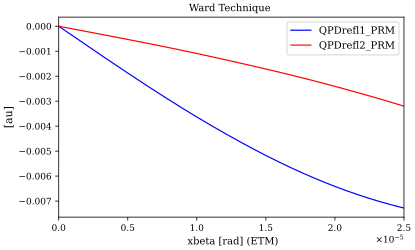

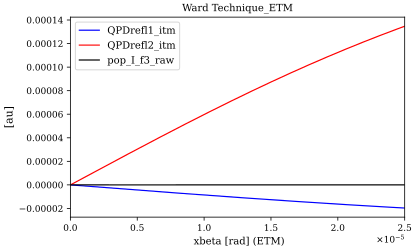

In [6]:
### ETM is sensed using QPDrefl1_itm and QPDrefl2_itm (second graph)###
### Guoy phase tuned such that the signals have opposite slope ###  

out1.plot(['QPDrefl1_PRM','QPDrefl2_PRM'],title='Ward Technique ')
out1.plot(['QPDrefl1_itm','QPDrefl2_itm','pop_I_f3_raw'],title='Ward Technique_ETM')

In [7]:
#i=0
#for i in np.arange(0,360, 10):
#    kat_ETM.sQPD11.gouy = i
#    kat_ETM.sQPD21.gouy = i+90
#    #i = i+40
#    out3 = kat_ETM.run()
#    #out3.info()
#    print(i)
#    out3.plot(['QPDrefl1_itm','QPDrefl2_itm','pop_I_f3_raw'],title='Ward Technique_ITM')
#    #out1.plot(['QPDrefl1','QPDrefl2'],title='Ward Technique ')

<h2>  ITM Angular Sensing</h2>

In [8]:
kat_ITM = kat.deepcopy()
kat_ITM.parse("""


#### LOCK ETM ####
set errs pop_I_f3_raw re
func errs4 = $errs*0.1
lock clocks $errs4 -3000 0.1n
put* ETM phi $clocks
noplot clocks
#####


xaxis ITM xbeta lin 0 25u 500

""")

out2 = kat_ITM.run()
out2.info()
#out.plot()

Parsing `set errs pop_I_f3_raw re` into pykat object not implemented yet, added as extra line.
--------------------------------------------------------------
Running kat - Started at 2022-10-21 22:16:33.756456


100% | ETA:  0:00:00 | Calculating - Locked X (Locking steps tried 41/10000)   

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 22.4691 seconds

--- Output info ---

Run date and time: 2022-10-21 22:16:33.757458
Detectors used: QPDrefl1, QPDrefl1_PRM, QPDrefl1_itm, QPDrefl2, QPDrefl2_PRM, QPDrefl2_itm, circ_arm, circ_prc, clocks, errs4, pop_I_f3_raw, pop_I_raw, pop_Q_f3_raw, pop_Q_raw, refl, refl_I, refl_I_f3, refl_Q, refl_Q_f3, trans

One xaxis used: ['xaxis ITM xbeta lin 0 2.5e-05 500']
QPDrefl1     : min = -1.385409827480910e-08 max = 1.033753229825190e-07
QPDrefl2     : min = 0.000000000000000e+00 max = 9.737234209899521e-08
QPDrefl1_itm : min = 0.000000000000000e+00 max = 1.805347539544470e-04
QPDrefl2_itm : min = -8.581878584367071e-05 max = 6.775899685179240e-07
circ_arm     : min = 2.293178524708470e+04 max = 3.657320815519020e+04
circ_prc     : min = 6.427900974413450e+01 max = 9.983353866387201e+01
refl         : min = 3.205159985132040e+00 max = 1.138125017552090e+01
trans        : min = 2.293270255518690e-01 max = 3.65

100% | ETA:  0:00:00 | Calculating - Locked X (Locking steps tried 40/10000)   

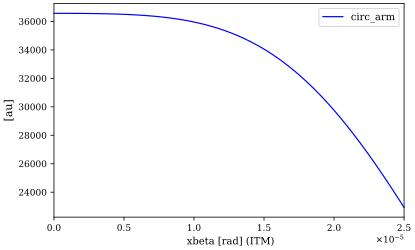

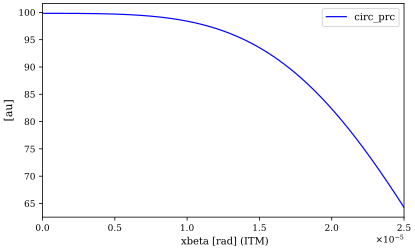

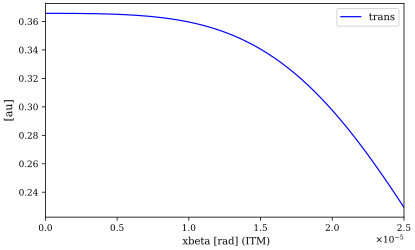

In [9]:
out2.plot(['circ_arm'])
out2.plot(['circ_prc'])
out2.plot(['trans'])

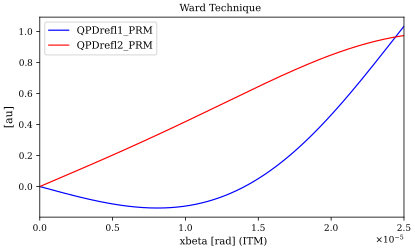

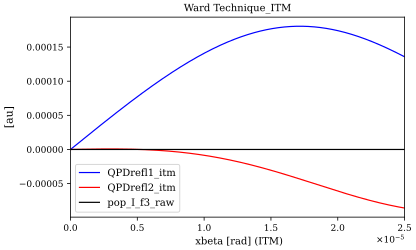

In [10]:
### ITM is sensed using QPDrefl1_itm and QPDrefl2_itm (second graph) effect can also be seen in first graph (PRM sensing)###
### Guoy phase tuned such that the one signal is zero###  

out2.plot(['QPDrefl1_PRM','QPDrefl2_PRM'],title='Ward Technique ')
out2.plot(['QPDrefl1_itm','QPDrefl2_itm','pop_I_f3_raw'],title='Ward Technique_ITM')

<h2>  PRM Angular Sensing</h2>

In [11]:
kat_PRM = kat.deepcopy()
kat_PRM.parse("""


#### LOCK PRM ####
set errs refl_I re
func errsn = $errs*50
lock clocks $errsn -3000 1n
put* PRM phi $clocks
noplot clocks
#####


xaxis PRM xbeta lin 0u 25u 500

""")

out3 = kat_PRM.run()
out3.info()
#out.plot()

Parsing `set errs refl_I re` into pykat object not implemented yet, added as extra line.
--------------------------------------------------------------
Running kat - Started at 2022-10-21 22:16:58.251120


 99% | ETA:  0:00:00 | Calculating - Locked X (Locking steps tried 13/10000)   

Used Finesse None at C:\Users\Parivesh\anaconda3\Library\bin\kat.exe

Finished in 17.6641 seconds

--- Output info ---

Run date and time: 2022-10-21 22:16:58.251119
Detectors used: QPDrefl1, QPDrefl1_PRM, QPDrefl1_itm, QPDrefl2, QPDrefl2_PRM, QPDrefl2_itm, circ_arm, circ_prc, clocks, errsn, pop_I_f3_raw, pop_I_raw, pop_Q_f3_raw, pop_Q_raw, refl, refl_I, refl_I_f3, refl_Q, refl_Q_f3, trans

One xaxis used: ['xaxis PRM xbeta lin 0 2.5e-05 500']
QPDrefl1     : min = 0.000000000000000e+00 max = 6.267625014868250e-08
QPDrefl2     : min = -3.392317339647800e-08 max = 0.000000000000000e+00
QPDrefl1_itm : min = -2.124879486902700e-04 max = 0.000000000000000e+00
QPDrefl2_itm : min = -8.830539262289430e-05 max = 0.000000000000000e+00
circ_arm     : min = 2.022036321698270e+04 max = 3.656835073700490e+04
circ_prc     : min = 5.591616653482780e+01 max = 9.982057524259589e+01
refl         : min = 3.208114838931960e+00 max = 1.319147505168520e+01
trans        : min = 2.022117206386520e-01 max = 3.6

100% | ETA:  0:00:00 | Calculating - Locked ✓ (Locking steps tried 15/10000)   

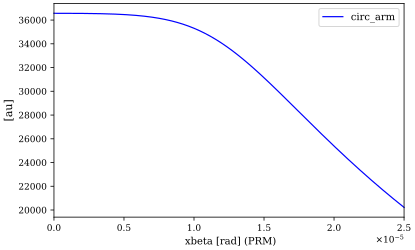

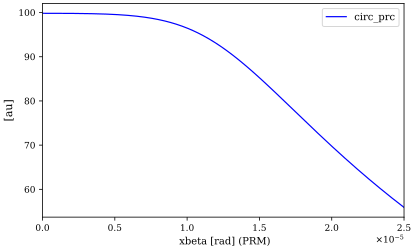

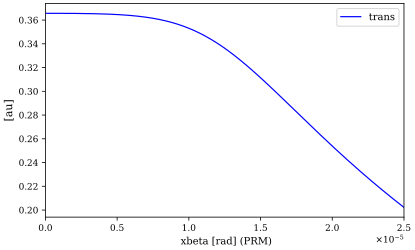

In [12]:
out3.plot(['circ_arm'])
out3.plot(['circ_prc'])
out3.plot(['trans'])

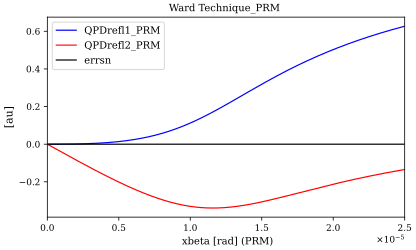

In [13]:
### PRM is sensed using QPDrefl1_PRM and QPDrefl1_PRM###
### Guoy phase tuned such that the one signal is zero###  

out3.plot(['QPDrefl1_PRM','QPDrefl2_PRM','errsn'],title='Ward Technique_PRM ')
#out3.plot(['QPDrefl1_itm','QPDrefl2_itm','pop_I_f3_raw'],title='Ward Technique_ITM')

In [14]:
#out3.plot(['refl_Q','refl_I'])
#out3.plot(['errsn'])
#out3.plot(['refl_I_f3','refl_Q_f3'])
#
#out3.plot(['pop_I_raw','pop_Q_raw'])
#out3.plot(['pop_I_f3_raw','pop_Q_f3_raw'])

In [15]:
#i=0
#for i in np.arange(0, 360,20):
#    kat_PRM.refl_I.phase1 = i
#    kat_PRM.sQPD1.gouy = i
#    kat_PRM.sQPD2.gouy = i+90
#    out3 = kat_PRM.run()
#    out3.info()
#    out3.plot(['QPDrefl1_PRM','QPDrefl2_PRM'],title='Ward Technique_PRM')
#    print(i)